In [1]:
import pandas as pd
data = pd.read_csv('./000660.csv')

In [2]:
data_000660 = data[['종가','거래량']]

In [3]:
data_000660.rename(columns={'종가':'Close',
                     '거래량':'Volume'},
            inplace=True)

C:\Users\F06\AppData\Local\Temp\ipykernel_12856\75747287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_000660.rename(columns={'종가':'Close',


In [14]:
data_000660 = data_000660[:251]

Epoch 1/200
109/109 [==============================] - 2s 17ms/step


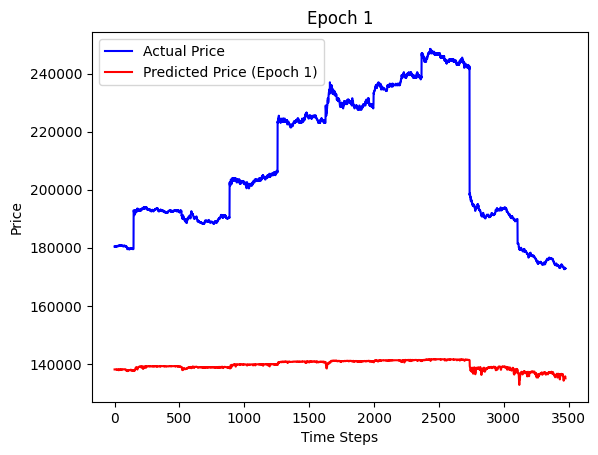

348/348 [==============================] - 21s 46ms/step - loss: 0.1024 - val_loss: 0.0361
Epoch 2/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 14s 41ms/step - loss: 0.0017 - val_loss: 0.0242
Epoch 3/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 6.2348e-04 - val_loss: 0.0251
Epoch 4/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 4.0800e-04 - val_loss: 0.0224
Epoch 5/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.6001e-04 - val_loss: 0.0217
Epoch 6/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.6756e-04 - val_loss: 0.0217
Epoch 7/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.5056e-04 - val_loss: 0.0189
Epoch 8/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.8461e-04 - val_loss: 0.0223
Epoch 9/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.2703e-04 - val_loss: 0.0296
Epoch 10/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.3236e-04 - val_loss: 0.0276
Epoch 11/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.5649e-04 - val_loss: 0.0234
Epoch 12/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.0440e-04 - val_loss: 0.0247
Epoch 13/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.0653e-04 - val_loss: 0.0285
Epoch 14/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.0695e-04 - val_loss: 0.0206
Epoch 15/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 45ms/step - loss: 1.8843e-04 - val_loss: 0.0264
Epoch 16/200
109/109 [==============================] - 1s 12ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.0434e-04 - val_loss: 0.0249
Epoch 17/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 14s 41ms/step - loss: 1.7307e-04 - val_loss: 0.0190
Epoch 18/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.8416e-04 - val_loss: 0.0210
Epoch 19/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.7819e-04 - val_loss: 0.0194
Epoch 20/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.0707e-04 - val_loss: 0.0161
Epoch 21/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.5473e-04 - val_loss: 0.0130
Epoch 22/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.8871e-04 - val_loss: 0.0208
Epoch 23/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.6405e-04 - val_loss: 0.0134
Epoch 24/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.6075e-04 - val_loss: 0.0108
Epoch 25/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.6162e-04 - val_loss: 0.0190
Epoch 26/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.3794e-04 - val_loss: 0.0159
Epoch 27/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.7796e-04 - val_loss: 0.0097
Epoch 28/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.5178e-04 - val_loss: 0.0111
Epoch 29/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.3764e-04 - val_loss: 0.0123
Epoch 30/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.3025e-04 - val_loss: 0.0085
Epoch 31/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.6702e-04 - val_loss: 0.0171
Epoch 32/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 46ms/step - loss: 1.3837e-04 - val_loss: 0.0115
Epoch 33/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.5625e-04 - val_loss: 0.0168
Epoch 34/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.3244e-04 - val_loss: 0.0151
Epoch 35/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.3257e-04 - val_loss: 0.0130
Epoch 36/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.2221e-04 - val_loss: 0.0195
Epoch 37/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.0787e-04 - val_loss: 0.0107
Epoch 38/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.4749e-04 - val_loss: 0.0290
Epoch 39/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.1270e-04 - val_loss: 0.0235
Epoch 40/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.2629e-04 - val_loss: 0.0257
Epoch 41/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.3802e-04 - val_loss: 0.0192
Epoch 42/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.1665e-04 - val_loss: 0.0253
Epoch 43/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.2339e-04 - val_loss: 0.0311
Epoch 44/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.0869e-04 - val_loss: 0.0235
Epoch 45/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.1047e-04 - val_loss: 0.0254
Epoch 46/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.2202e-04 - val_loss: 0.0238
Epoch 47/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.0618e-04 - val_loss: 0.0287
Epoch 48/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.2610e-04 - val_loss: 0.0335
Epoch 49/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 9.7530e-05 - val_loss: 0.0255
Epoch 50/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.0695e-04 - val_loss: 0.0282
Epoch 51/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.1771e-04 - val_loss: 0.0272
Epoch 52/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 8.0391e-05 - val_loss: 0.0259
Epoch 53/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.8640e-05 - val_loss: 0.0172
Epoch 54/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 9.1391e-05 - val_loss: 0.0246
Epoch 55/200
109/109 [==============================] - 1s 13ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 9.4690e-05 - val_loss: 0.0180
Epoch 56/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.1103e-05 - val_loss: 0.0188
Epoch 57/200
109/109 [==============================] - 1s 13ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.0705e-05 - val_loss: 0.0250
Epoch 58/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 14s 42ms/step - loss: 7.8414e-05 - val_loss: 0.0352
Epoch 59/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.2366e-05 - val_loss: 0.0266
Epoch 60/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 4.8119e-05 - val_loss: 0.0316
Epoch 61/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 4.0751e-05 - val_loss: 0.0431
Epoch 62/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 4.8061e-05 - val_loss: 0.0363
Epoch 63/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 3.1144e-05 - val_loss: 0.0302
Epoch 64/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 3.2478e-05 - val_loss: 0.0354
Epoch 65/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 3.1957e-05 - val_loss: 0.0341
Epoch 66/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 3.4190e-05 - val_loss: 0.0229
Epoch 67/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.0633e-05 - val_loss: 0.0232
Epoch 68/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.9255e-05 - val_loss: 0.0188
Epoch 69/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.3665e-05 - val_loss: 0.0093
Epoch 70/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.8089e-05 - val_loss: 0.0229
Epoch 71/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.0075e-05 - val_loss: 0.0184
Epoch 72/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.9150e-05 - val_loss: 0.0174
Epoch 73/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.1227e-05 - val_loss: 0.0166
Epoch 74/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.2648e-05 - val_loss: 0.0195
Epoch 75/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.7907e-05 - val_loss: 0.0182
Epoch 76/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.6507e-05 - val_loss: 0.0239
Epoch 77/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.7477e-05 - val_loss: 0.0205
Epoch 78/200
109/109 [==============================] - 1s 12ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.8629e-05 - val_loss: 0.0198
Epoch 79/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.2516e-05 - val_loss: 0.0179
Epoch 80/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 14s 41ms/step - loss: 1.5361e-05 - val_loss: 0.0227
Epoch 81/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 2.0685e-05 - val_loss: 0.0253
Epoch 82/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.0873e-05 - val_loss: 0.0250
Epoch 83/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.5228e-05 - val_loss: 0.0265
Epoch 84/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.8327e-05 - val_loss: 0.0325
Epoch 85/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.8889e-05 - val_loss: 0.0414
Epoch 86/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.4767e-05 - val_loss: 0.0343
Epoch 87/200
109/109 [==============================] - 1s 12ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.5821e-05 - val_loss: 0.0421
Epoch 88/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.5825e-05 - val_loss: 0.0514
Epoch 89/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.5046e-05 - val_loss: 0.0456
Epoch 90/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.7577e-05 - val_loss: 0.0527
Epoch 91/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.9706e-05 - val_loss: 0.0186
Epoch 92/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.5372e-05 - val_loss: 0.0346
Epoch 93/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.2250e-05 - val_loss: 0.0264
Epoch 94/200
109/109 [==============================] - 2s 18ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1058e-05 - val_loss: 0.0409
Epoch 95/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.2542e-05 - val_loss: 0.0394
Epoch 96/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.5094e-05 - val_loss: 0.0365
Epoch 97/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.5479e-05 - val_loss: 0.0426
Epoch 98/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 2.9828e-05 - val_loss: 0.0562
Epoch 99/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.3782e-05 - val_loss: 0.0422
Epoch 100/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.0702e-05 - val_loss: 0.0407
Epoch 101/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.0563e-05 - val_loss: 0.0334
Epoch 102/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 46ms/step - loss: 2.0832e-05 - val_loss: 0.0209
Epoch 103/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.3163e-05 - val_loss: 0.0534
Epoch 104/200
109/109 [==============================] - 2s 19ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 46ms/step - loss: 1.2774e-05 - val_loss: 0.0901
Epoch 105/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.1857e-05 - val_loss: 0.1005
Epoch 106/200
109/109 [==============================] - 2s 14ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 46ms/step - loss: 1.3012e-05 - val_loss: 0.0952
Epoch 107/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.2889e-05 - val_loss: 0.1181
Epoch 108/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1531e-05 - val_loss: 0.1305
Epoch 109/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.1951e-05 - val_loss: 0.1288
Epoch 110/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1870e-05 - val_loss: 0.1425
Epoch 111/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.2111e-05 - val_loss: 0.1504
Epoch 112/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.2850e-05 - val_loss: 0.1684
Epoch 113/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.5431e-05 - val_loss: 0.1722
Epoch 114/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.3518e-05 - val_loss: 0.1727
Epoch 115/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 14s 42ms/step - loss: 1.8469e-05 - val_loss: 0.1810
Epoch 116/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.7745e-06 - val_loss: 0.1838
Epoch 117/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1096e-05 - val_loss: 0.1905
Epoch 118/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1160e-05 - val_loss: 0.1764
Epoch 119/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.2138e-05 - val_loss: 0.1908
Epoch 120/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.2826e-05 - val_loss: 0.1908
Epoch 121/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.7661e-05 - val_loss: 0.1276
Epoch 122/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 1.0779e-05 - val_loss: 0.1423
Epoch 123/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0067e-05 - val_loss: 0.1411
Epoch 124/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.4139e-05 - val_loss: 0.1651
Epoch 125/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1902e-05 - val_loss: 0.1462
Epoch 126/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0780e-05 - val_loss: 0.1576
Epoch 127/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0188e-05 - val_loss: 0.1683
Epoch 128/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0901e-05 - val_loss: 0.1635
Epoch 129/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.5800e-06 - val_loss: 0.1657
Epoch 130/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0432e-05 - val_loss: 0.1715
Epoch 131/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.1517e-05 - val_loss: 0.1363
Epoch 132/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.3383e-05 - val_loss: 0.1562
Epoch 133/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.2185e-05 - val_loss: 0.1591
Epoch 134/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0553e-05 - val_loss: 0.1832
Epoch 135/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0660e-05 - val_loss: 0.1644
Epoch 136/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.9654e-06 - val_loss: 0.1780
Epoch 137/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.4054e-06 - val_loss: 0.1713
Epoch 138/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.7066e-06 - val_loss: 0.1828
Epoch 139/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1559e-05 - val_loss: 0.1802
Epoch 140/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.7987e-06 - val_loss: 0.1967
Epoch 141/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.1244e-06 - val_loss: 0.1974
Epoch 142/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.5322e-06 - val_loss: 0.1877
Epoch 143/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0549e-05 - val_loss: 0.1893
Epoch 144/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.2062e-05 - val_loss: 0.1711
Epoch 145/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1274e-05 - val_loss: 0.1726
Epoch 146/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0076e-05 - val_loss: 0.1772
Epoch 147/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.7043e-06 - val_loss: 0.1767
Epoch 148/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.8233e-06 - val_loss: 0.1857
Epoch 149/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 1.1203e-05 - val_loss: 0.1911
Epoch 150/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.0396e-05 - val_loss: 0.1857
Epoch 151/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 8.5696e-06 - val_loss: 0.1836
Epoch 152/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.2942e-06 - val_loss: 0.1868
Epoch 153/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.3588e-06 - val_loss: 0.1917
Epoch 154/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.0274e-05 - val_loss: 0.1764
Epoch 155/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.9255e-06 - val_loss: 0.1804
Epoch 156/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.7634e-06 - val_loss: 0.1817
Epoch 157/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.5930e-06 - val_loss: 0.1872
Epoch 158/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0026e-05 - val_loss: 0.1897
Epoch 159/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.9137e-06 - val_loss: 0.1812
Epoch 160/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 8.1237e-06 - val_loss: 0.1840
Epoch 161/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.6786e-05 - val_loss: 0.0124
Epoch 162/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0697e-05 - val_loss: 0.0109
Epoch 163/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.0974e-06 - val_loss: 0.0117
Epoch 164/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.0019e-05 - val_loss: 0.0113
Epoch 165/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.3637e-06 - val_loss: 0.0144
Epoch 166/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 8.0861e-06 - val_loss: 0.0152
Epoch 167/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.7235e-06 - val_loss: 0.0166
Epoch 168/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 8.4925e-06 - val_loss: 0.0160
Epoch 169/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.0523e-06 - val_loss: 0.0170
Epoch 170/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.8095e-06 - val_loss: 0.0201
Epoch 171/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.1564e-06 - val_loss: 0.0207
Epoch 172/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.4820e-06 - val_loss: 0.0205
Epoch 173/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.1272e-05 - val_loss: 0.0211
Epoch 174/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.0188e-06 - val_loss: 0.0235
Epoch 175/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 8.0971e-06 - val_loss: 0.0235
Epoch 176/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.3598e-06 - val_loss: 0.0247
Epoch 177/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 8.8991e-06 - val_loss: 0.0280
Epoch 178/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.1410e-06 - val_loss: 0.0328
Epoch 179/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 1.3167e-05 - val_loss: 0.0436
Epoch 180/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.7496e-06 - val_loss: 0.0348
Epoch 181/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.8025e-06 - val_loss: 0.0287
Epoch 182/200
109/109 [==============================] - 1s 13ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 8.5765e-06 - val_loss: 0.0327
Epoch 183/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 42ms/step - loss: 8.5847e-06 - val_loss: 0.0388
Epoch 184/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 6.9877e-06 - val_loss: 0.0444
Epoch 185/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 2.7166e-05 - val_loss: 0.0308
Epoch 186/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 16s 45ms/step - loss: 9.2645e-06 - val_loss: 0.0508
Epoch 187/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.8795e-06 - val_loss: 0.0711
Epoch 188/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0105e-05 - val_loss: 0.0677
Epoch 189/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.6936e-06 - val_loss: 0.0741
Epoch 190/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 7.9451e-06 - val_loss: 0.0814
Epoch 191/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0057e-05 - val_loss: 0.0929
Epoch 192/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 43ms/step - loss: 8.0578e-06 - val_loss: 0.1012
Epoch 193/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.2437e-06 - val_loss: 0.0885
Epoch 194/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.5605e-06 - val_loss: 0.0975
Epoch 195/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 9.1227e-06 - val_loss: 0.1005
Epoch 196/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 8.6667e-06 - val_loss: 0.1112
Epoch 197/200
109/109 [==============================] - 2s 15ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 15s 44ms/step - loss: 1.0296e-05 - val_loss: 0.1207
Epoch 198/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 17s 50ms/step - loss: 8.0033e-06 - val_loss: 0.0690
Epoch 199/200
109/109 [==============================] - 2s 16ms/step


<Figure size 640x480 with 0 Axes>

348/348 [==============================] - 14s 41ms/step - loss: 9.3551e-06 - val_loss: 0.0651
Epoch 200/200
109/109 [==============================] - 2s 17ms/step


<Figure size 640x480 with 0 Axes>

109/109 [==============================] - 2s 17ms/step
      Date Action      Balance  Position  Portfolio Value  Predicted Price  \
0        0   HOLD  10000.00000  0.000000     10000.000000    123138.960938   
1        1   HOLD  10000.00000  0.000000     10000.000000    123129.265625   
2        2   HOLD  10000.00000  0.000000     10000.000000    123117.242188   
3        3    BUY      0.00000  0.055432     10000.000000    123089.726562   
4        4   HOLD      0.00000  0.055432     10000.000000    123091.460938   
...    ...    ...          ...       ...              ...              ...   
3472  3472   SELL  13247.95245  0.000000     13247.952450    130327.914062   
3473  3473    BUY      0.00000  0.076622     13247.952450    130280.398438   
3474  3474   HOLD      0.00000  0.076622     13232.628040    130294.093750   
3475  3475   HOLD      0.00000  0.076622     13255.614655    130335.953125   
3476  3476    END      0.00000  0.076622     13247.952450    130383.953125   

       

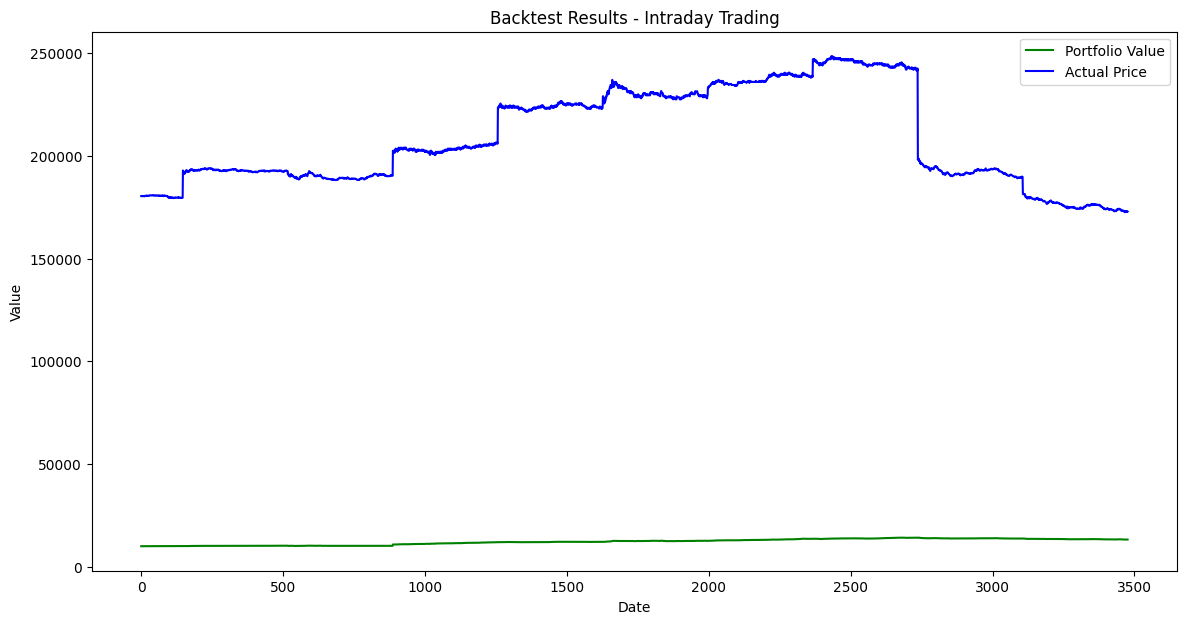

MovieWriter imagemagick unavailable; using Pillow instead.


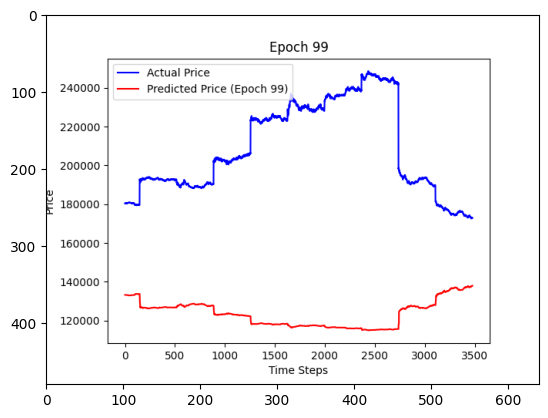

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers , Model
from sklearn.preprocessing import MinMaxScaler
import os
from matplotlib.animation import FuncAnimation

def download_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df[['Close','Volume']].values

# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [],[]
    for i in range(len(data) - seq_length):
        X.append(data[i:i+ seq_length])
        y.append(data[i + seq_length, 0]) # 종가(Close) 예측
    return np.array(X), np.array(y)

# TimesNet 모델 구현
class TimeSeriesTransform(layers.Layer):
    def __init__(self, d_model, num_harmonics=64):
        super(TimeSeriesTransform, self).__init__()
        self.num_harmonics = num_harmonics
        self.dense = layers.Dense(d_model) # 출력 크기를 d_model로 맞춤

    def call(self, inputs):
        # 주파수 도메인으로 변환
        freq_data = tf.signal.rfft(inputs)
        freq_data = tf.concat([tf.math.real(freq_data), tf.math.imag(freq_data)], axis=-1)
        freq_data = freq_data[:,:,:self.num_harmonics]
        return self.dense(freq_data) # 출력 크키를 d_model로 맞춤

class TimeSeriesBlock(Model):
    def __init__(self, d_model, num_harmonics):
        super(TimeSeriesBlock, self).__init__()
        self.time_transform = TimeSeriesTransform(d_model, num_harmonics)
        self.multihead_attn = layers.MultiHeadAttention(num_heads=8, key_dim=d_model)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(4 * d_model, activation='relu')
            , layers.Dense(d_model)
            , layers.Dropout(0.1)
        ])
    def call(self, x, training):
        x= self.time_transform(x)
        attn_output = self.multihead_attn(x, x)
        out1 = self.norm1(x + attn_output)
        ffn_output = self.ffn(out1, training=training)
        return self.norm2(out1 + ffn_output)

class TimesNet(Model):
    def __init__(self, input_dim, d_model, num_layers, num_harmonics, output_dim):
        super(TimesNet, self).__init__()
        self.input_proj = layers.Dense(d_model) # 입력 차원 맞추기
        self.blocks = [TimeSeriesBlock(d_model, num_harmonics) for _ in range(num_layers)]
        self.output_proj = layers.Dense(output_dim)

    def call(self, x, training):
        x = self.input_proj(x) # 입력 크기 조정
        for block in self.blocks:
            x = block(x, training)
        return self.output_proj(x[:, -1,:])

# 실시간 시각화 콜백 정의
class RealTimePlot(tf.keras.callbacks.Callback):
    def __init__(self, model, X_test, y_test, scaler, save_dir='plots'):
        super(RealTimePlot, self).__init__()
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.scaler = scaler
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.fig, self.ax = plt.subplots()
        self.predicted = []
        self.actual = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0]
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.X_test)
        self.predicted = self.scaler.inverse_transform(np.c_[pred, np.zeros_like(pred)])[:, 0]

        self.ax.clear()
        self.ax.plot(self.actual, label='Actual Price', color='blue')
        self.ax.plot(self.predicted, label=f'Predicted Price (Epoch {epoch+1})', color='red')
        self.ax.set_title(f'Epoch {epoch+1}')
        self.ax.set_xlabel('Time Steps')
        self.ax.set_ylabel('Price')
        self.ax.legend()

        plt.draw()
        plt.pause(0.001)
        save_path = os.path.join(self.save_dir, f'epoch_{epoch+1}.png')
        self.fig.savefig(save_path)
        
    def on_train_end(self, logs=None):
        plt.ioff()
        plt.show()

# 백테스트 함수 정의
def backtest(model, X_test, y_test, scaler, initial_balance=10000):
    balance = initial_balance
    position = 0
    history = []

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(np.c_[y_pred_scaled, np.zeros_like(y_pred_scaled)])[:, 0]
    y_true = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0] 

    for i in range(len(y_pred) - 1):
        if y_pred[i+1] > y_pred[i]:
            if balance > 0:
                buy_amount = balance / y_true[i]
                position += buy_amount
                balance = 0
                action = 'BUY'
            else:
                action = 'HOLD'
        elif y_pred[i + 1] < y_pred[i]:
            if position > 0:
                balance += position * y_true[i]
                position = 0
                action = 'SELL'
            else:
                action = 'HOLD'
        else:
            action = 'HOLD'

        history.append({
            'Date': i,
            'Action': action,
            'Balance': balance,
            'Position': position,
            'Portfolio Value': balance + position * y_true[i],
            'Predicted Price': y_pred[i],
            'Actual Price': y_true[i]
        })

    final_value = balance + position * y_true[-1]
    history.append({
        'Date': len(y_pred) - 1,
        'Action': 'END',
        'Balance': balance,
        'Position': position,
        'Portfolio Value': final_value,
        'Predicted Price': y_pred[-1],
        'Actual Price': y_true[-1]
        })

    df_history = pd.DataFrame(history)
    return df_history

# 애니메이션 생성 함수
def create_animation(image_dir, output_file, fps=2):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    first_image = plt.imread(os.path.join(image_dir, image_files[0]))
    fig, ax = plt.subplots()
    img = ax.imshow(first_image)

    def update(frame):
        img.set_data(plt.imread(os.path. join(image_dir, image_files[frame])))
        return [img]

    anim = FuncAnimation(fig, update, frames=len(image_files), interval=1000/fps)
    anim.save(output_file, writer='imagemagick', fps=fps)
    plt.show()

# # 데이터 다운로드 및 전처리
# ticker = 'AAPL'
# start_date = '2022-01-01'
# end_date = '2023-01-01'
# data = download_stock_data(ticker, start_date, end_date)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data_000660.values)

# 시퀀스 데이터 생성
seq_length = 5
X, y = create_sequences(data, seq_length)

# 시간 순서에 따른 데이터 분할
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# TensorFlow 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# 모델 초기화 및 컴파일
input_dim= X_train.shape[-1] # 특성 수에 맞춤
d_model = 64
num_layers = 3
num_harmonics = 16
output_dim = 1

model = TimesNet(input_dim, d_model, num_layers, num_harmonics, output_dim)
model.compile(optimizer='adam', loss='mse')

# 실시간 시각화 콜백 인스턴스 생성
real_time_plot = RealTimePlot(model, X_test, y_test, scaler, save_dir='plots')

# 모델 학습
model.fit(
    X_train,
    y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[real_time_plot]
    )

# 백테스트 실행
backtest_results = backtest(model, X_test, y_test, scaler, initial_balance=10000)

# 백테스트 결과 출력
print(backtest_results)

# 백테스트 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(backtest_results ['Date' ], backtest_results['Portfolio Value'], label='Portfolio Value', color='green')
plt.plot(backtest_results ['Date' ], backtest_results['Actual Price'], label='Actual Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Backtest Results - Intraday Trading')
plt.legend()
plt.show()

# 애니메이션 생성
create_animation(image_dir='plots', output_file='predictions animation.gif', fps=2)

In [13]:
data.values

,Close,Volume
Date,,
2022-01-03,182.009995,104487900
2022-01-04,179.699997,99310400
2022-01-05,174.919998,94537600
2022-01-06,172.000000,96904000
2022-01-07,172.169998,86709100
...,...,...
2022-12-23,131.860001,63814900
2022-12-27,130.029999,69007800
2022-12-28,126.040001,85438400


In [8]:
data_000660.describe()

,Close,Volume
count,17390.000000,17390.000000
mean,131934.669350,12154.698390
std,48871.451716,15628.985772
min,73100.000000,202.000000
25%,87125.000000,3449.000000
50%,119100.000000,7199.500000
75%,177600.000000,14667.000000
max,248500.000000,385039.000000
